# Basic test for correlation

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm import tqdm

from dataset.midi import process_midi_separating_instruments_mido

from ripdalib.utils.morphology import erosion, dilation

In [2]:
data = process_midi_separating_instruments_mido("./bach_846.mid", 16)
data.keys()

dict_keys(['midi_file', 'Piano right', 'Piano left', 'Fuga 1', 'Fuga 2', 'Fuga 3', 'Fuga 4'])

In [10]:
def basic_plot(tracks):
    plt.figure(figsize=(20, 10))
    for track in tracks.values():
        onsets = [elem[0] for elem in track]
        pitches = [elem[1] for elem in track]

        plt.scatter(onsets, pitches)

    plt.show()


def merge_instruments(tracks):
    merged = list()
    for name, track in tracks.items():
        if not name == "midi_file":
            merged.extend(track)
    merged = sorted(merged, key=lambda x: x[0])
    return merged

def settable(list_list):
    return [(elem[0], elem[1]) for elem in list_list]

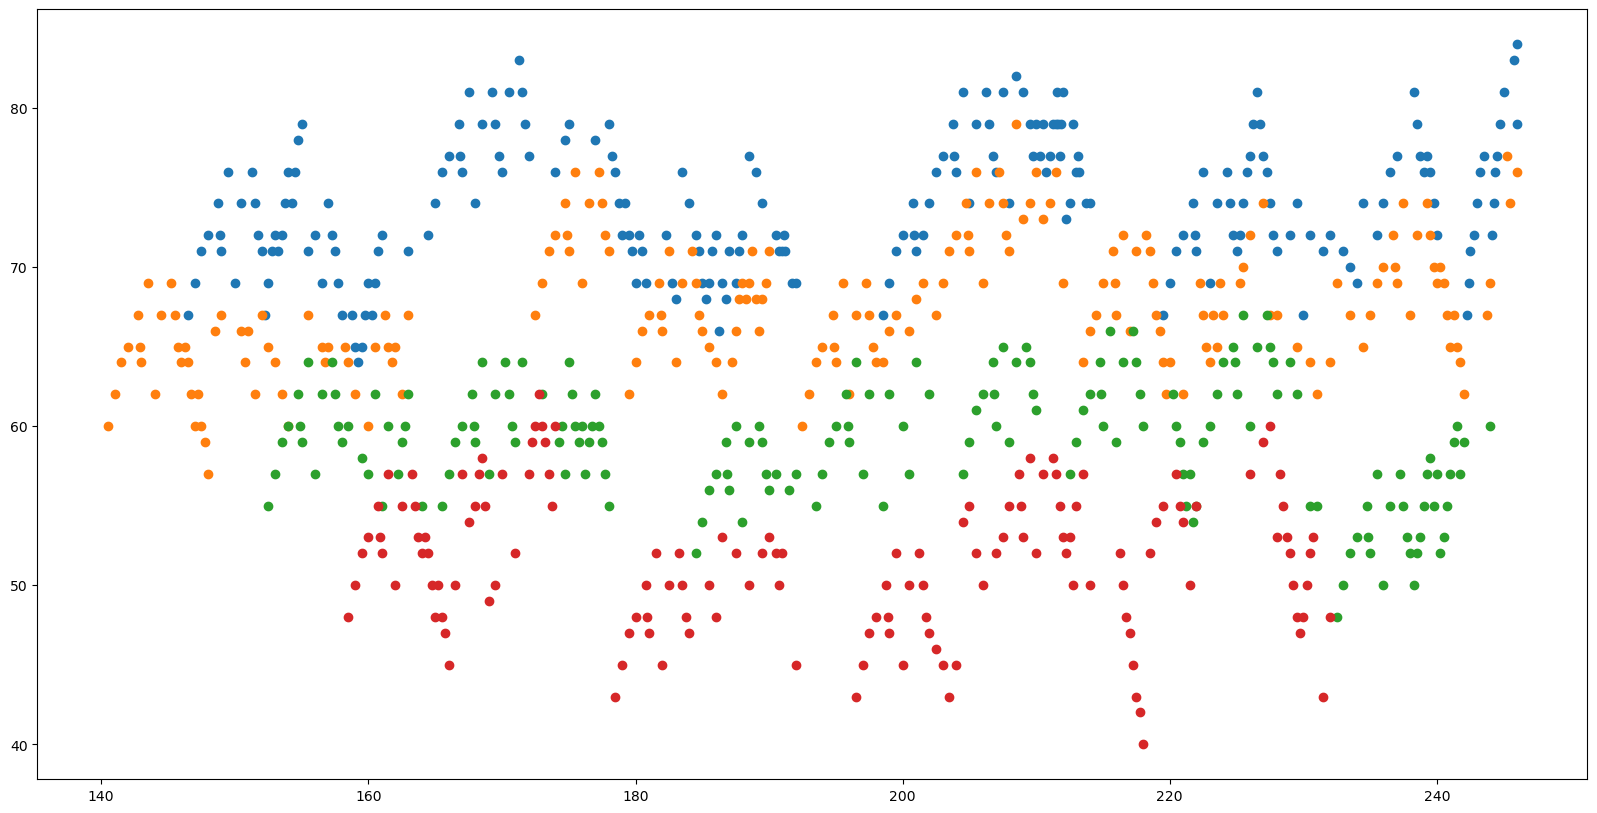

In [8]:
tracks = {key: data[key] for key in ('Fuga 1', 'Fuga 2', 'Fuga 3', 'Fuga 4')}
basic_plot(tracks)

In [ ]:
subject = data['Fuga 2'][:13]

[[Fraction(281, 2), 60], [Fraction(141, 1), 62], [Fraction(283, 2), 64], [Fraction(142, 1), 65], [Fraction(571, 4), 67], [Fraction(1143, 8), 65], [Fraction(143, 1), 64], [Fraction(287, 2), 69], [Fraction(144, 1), 62], [Fraction(289, 2), 67], [Fraction(581, 4), 69], [Fraction(291, 2), 67], [Fraction(583, 4), 65]]


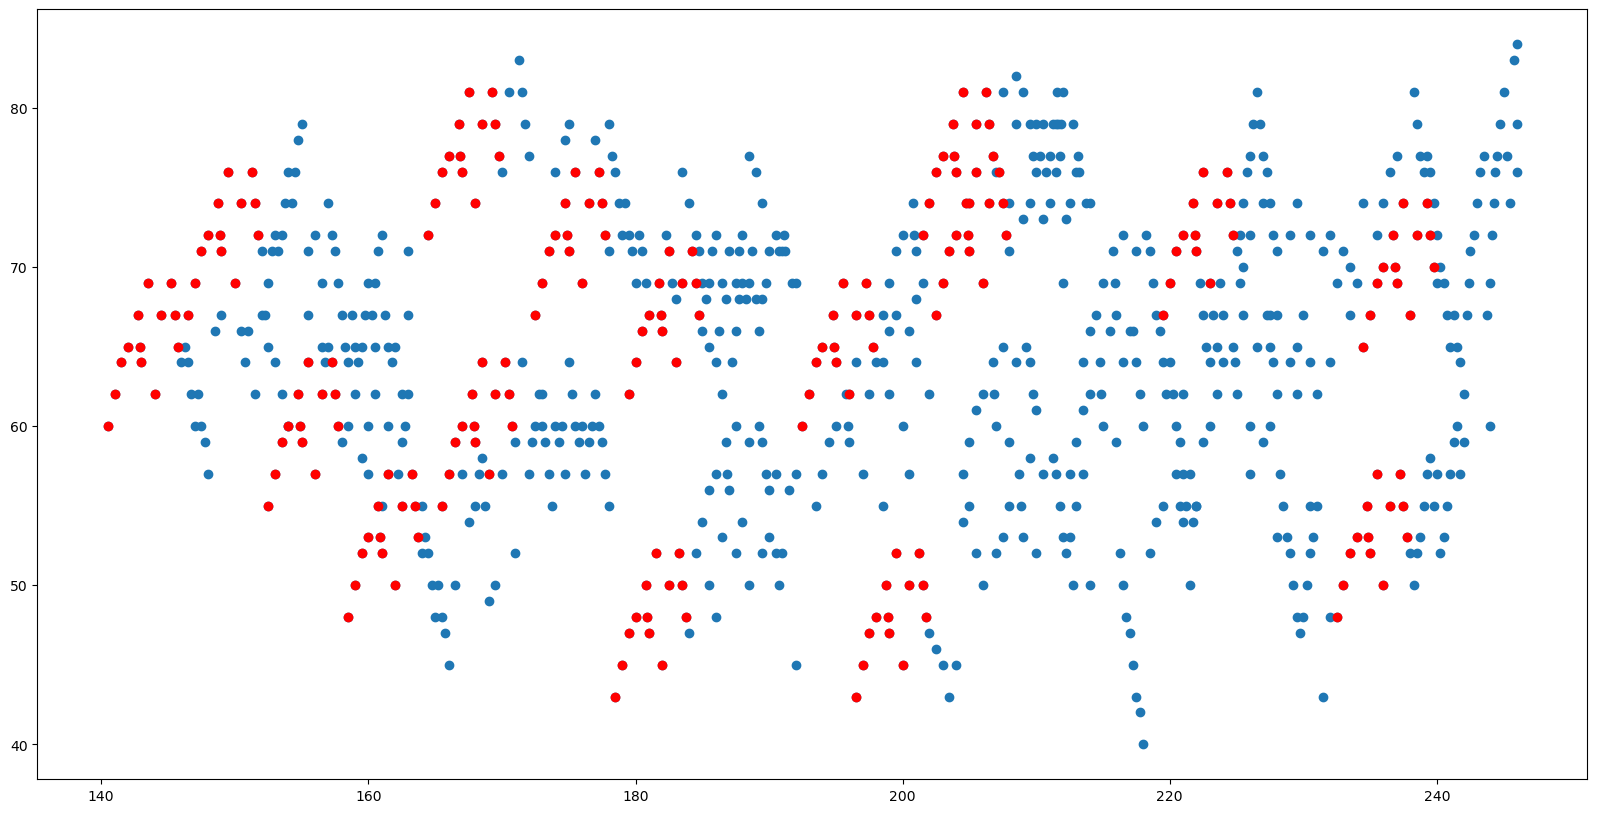

In [18]:
fugua = merge_instruments(tracks)
fugua = settable(fugua)
subject = settable(subject)

subject_onsets = erosion(fugua, subject)
subject_all = dilation(subject, subject_onsets)

plt.figure(figsize=(20, 10))
plt.scatter(*zip(*fugua))
plt.scatter(*zip(*subject_all), color='red')
plt.show()